### Is AK-47 | Redline a good investment?

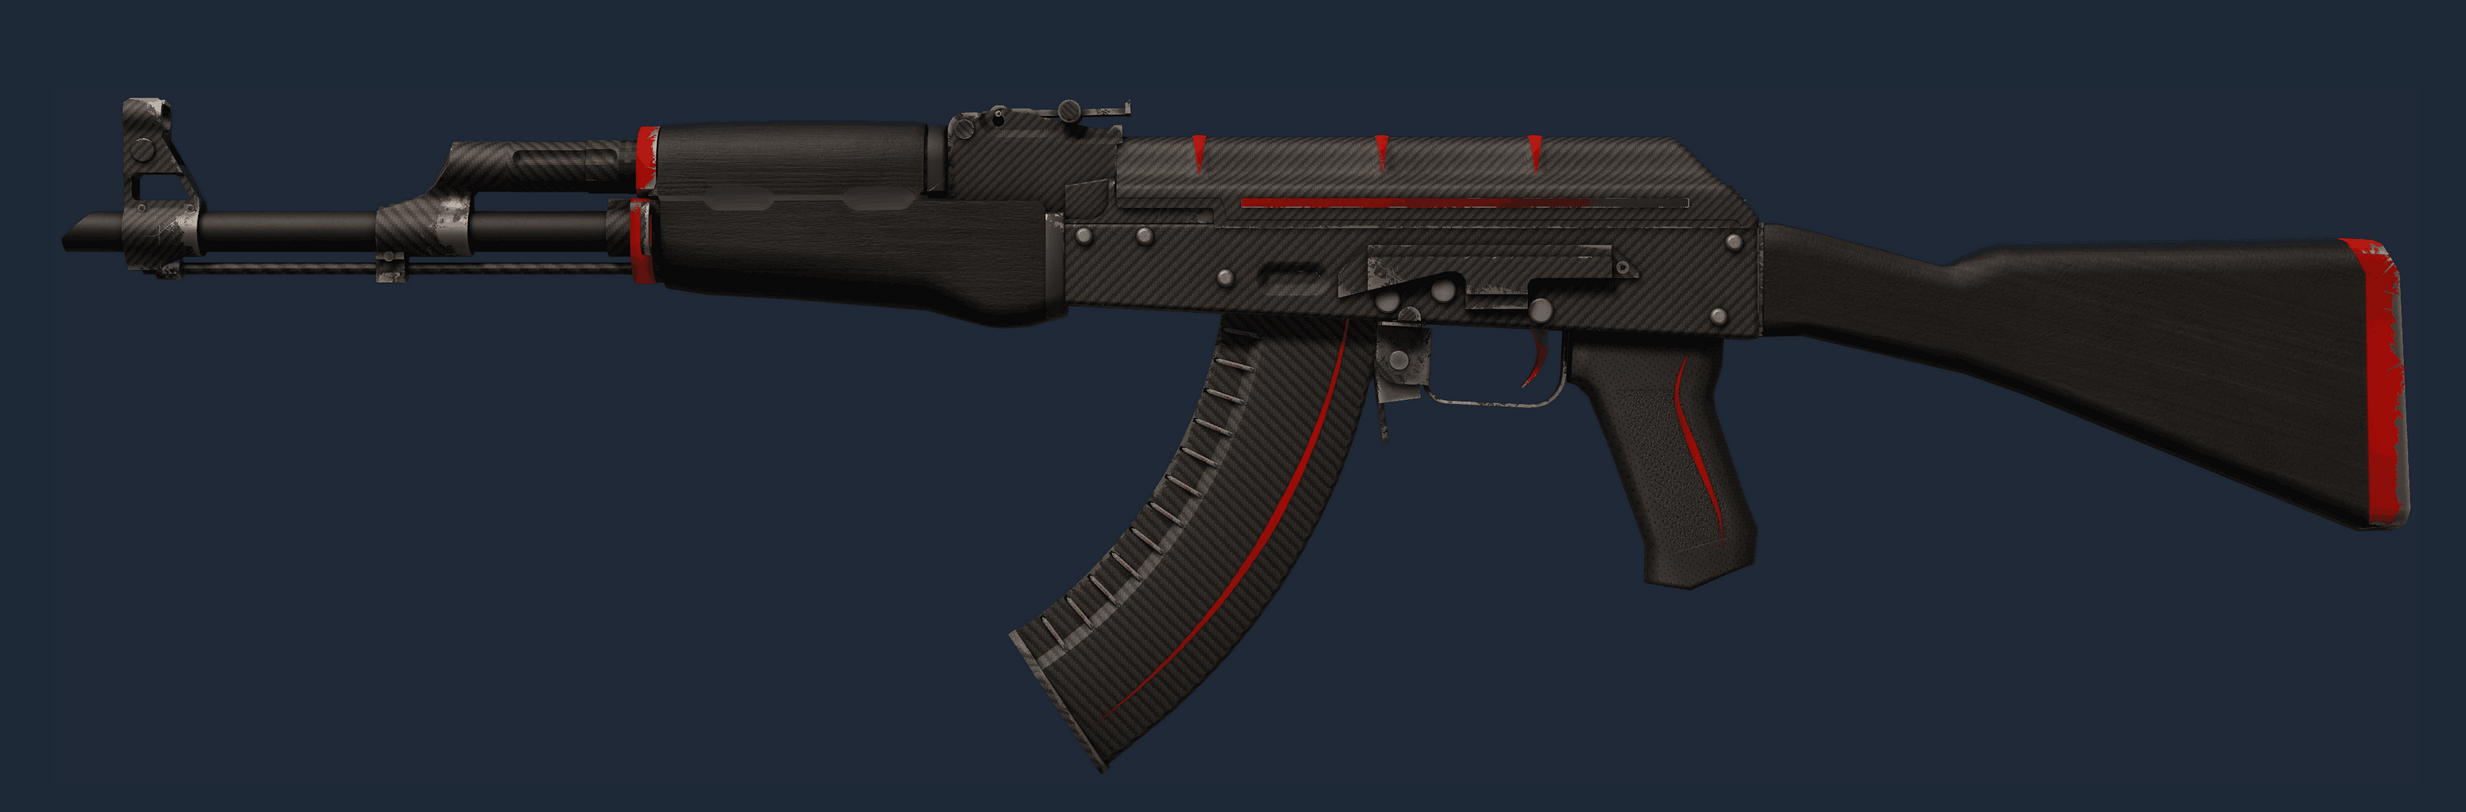

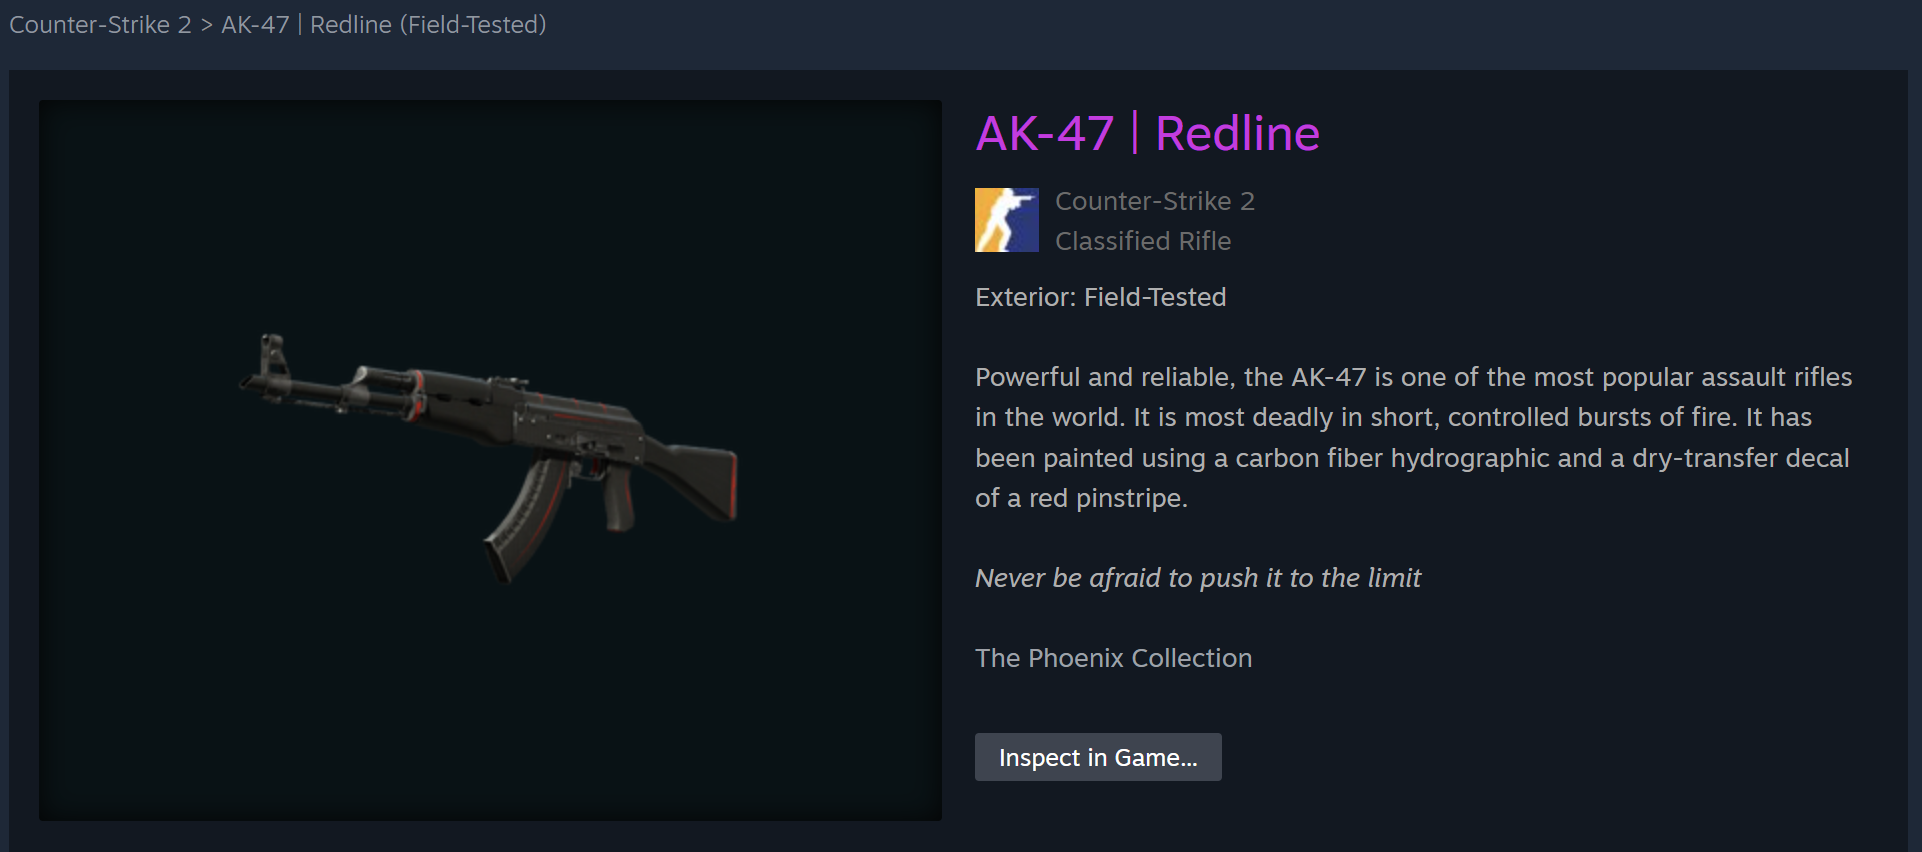

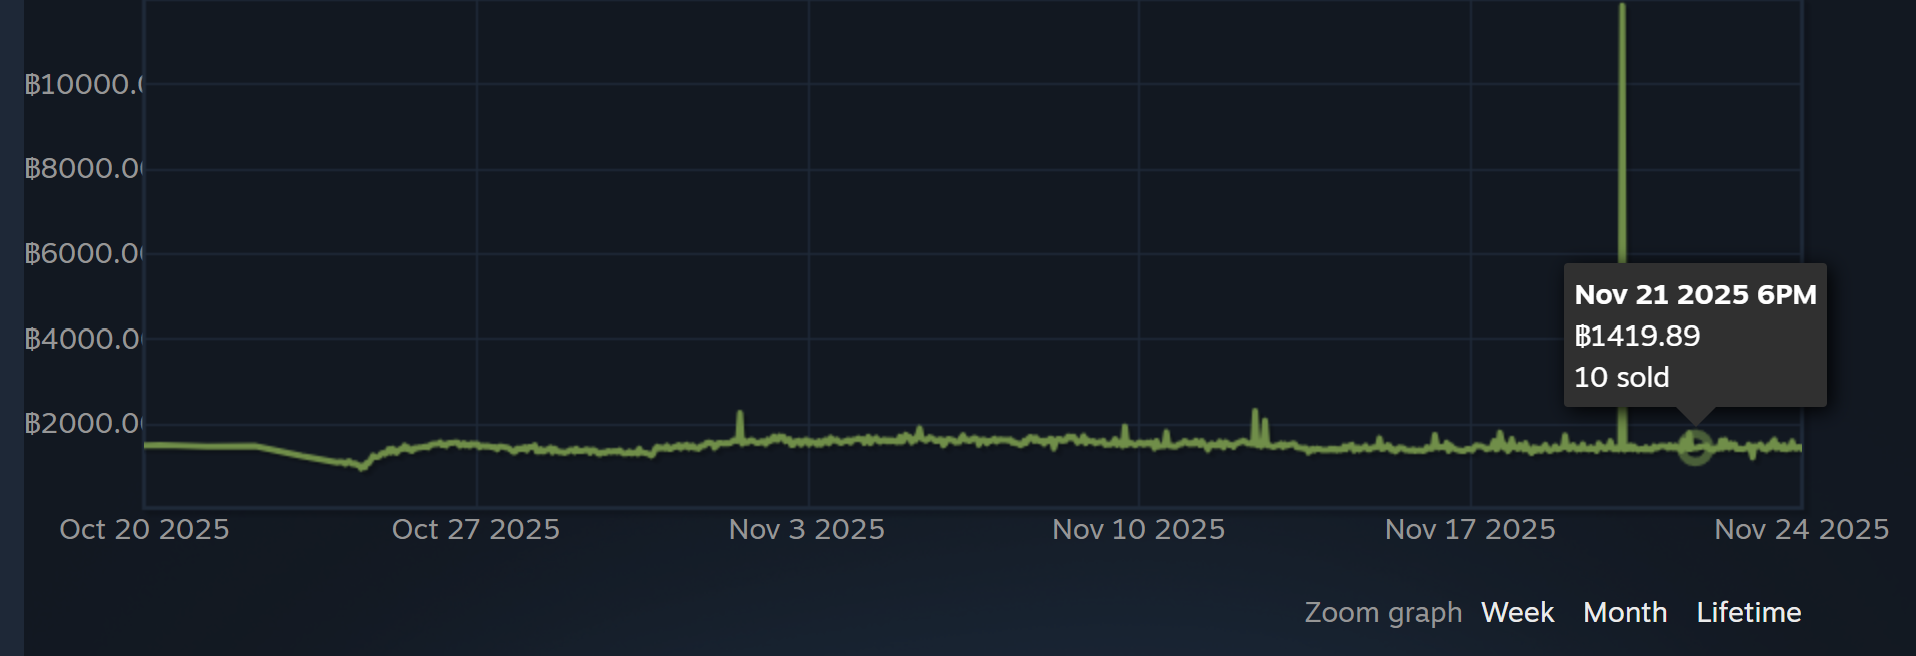

Let's find out by using Linear Regression and Monte Carlo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

prices = np.array([
    1388.14,
    1468.46,
    1421.67,
    1398.19,
    1778.04,
    1390.37,
    1527.63,
    1456.89,
    1766.20,
    1495.08,
    1568.40
])

daily_return = (prices[1:] - prices[:-1]) / prices[:-1]
print(f"Daily returns is: {daily_return}")
# for example (1468.46 - 1388.14)/1388.14 = 0.058

Daily returns is: [ 0.0578616  -0.03186331 -0.01651579  0.27167266 -0.21803222  0.09872192
 -0.04630702  0.21230841 -0.1535047   0.04904085]


We need Sigma and Mu (μ) to feed the Monte Carlo, so first let's find Sigma by using standard deviation.

In [13]:
sigma_daily = np.std(daily_return, ddof=1)
sigma_yearly = sigma_daily * np.sqrt(252)

print(f"Daily Sigma: {sigma_daily}")
print(f"Yearly Sigma: {sigma_yearly}")

Daily Sigma: 0.1505264970172573
Yearly Sigma: 2.3895340610002123


Next step let's do Linear Regression to get Mu

In [17]:
days = np.arange(len(prices))
m, b = np.polyfit(days, prices, 1) # degree 1 is just for linear

print(f"Slope m: {m}")
print(f"Intercept b: {b}")

Slope m: 17.34872727272725
Intercept b: 1427.7172727272728


Using Geometric Brownian Motion.

$$s(t+dt) = s(t) + s(t)(\mu dt + \epsilon\sigma \sqrt{dt}) $$

In [ ]:
def price_next(s, dt, mu, sigma):
    z = np.random.randn()
    return s + s*(mu * dt + sigma * np.sqrt(dt) * z)

### Is stock a good investment choice?

Let's find out using Linear Regression and Monte Carlo.

Regression is use to find Mu and feed it into Monte Carlo to do simulations.

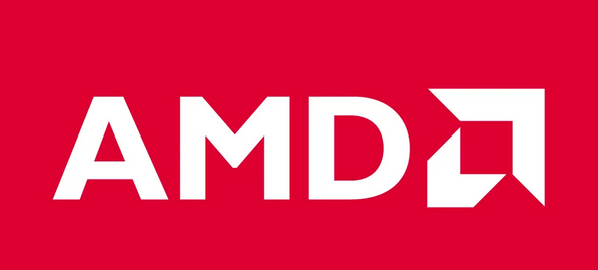

C:\Users\Asus\AppData\Local\Temp\ipykernel_12448\3371708555.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  amd = yf.download("AMD", period="1y")
[*********************100%***********************]  1 of 1 completed


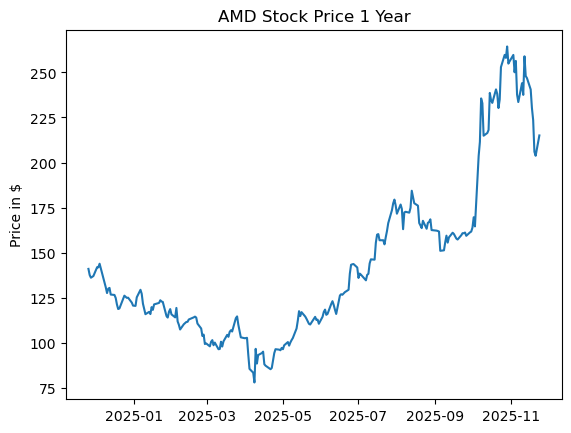

In [ ]:
import yfinance as yf
import pandas as pd

amd = yf.download("AMD", period="1y")

plt.plot(amd.index, amd["Close"])
plt.ylabel("Price in $")
plt.title("AMD Stock Price 1 Year")
plt.show()

amd.to_csv("amd_stock.csv")
# save to csv so we can use it later on to find return mu and sigm

Let's load the data we just fetched then calulate return and get Volatility (or sigma).


$$\text{daily return} = \frac{P_{today} - P_{yesterday}}{P_{yesterday}}$$

Daily return measure how much the price changes each day.

Monte Carlo uses annual Mu and Sigma that's why we need to convert it into yearly too.

$$\sigma_{\text{day}} = \text{std}(\text{daily return})$$


$$\sigma_{\text{year}} = \sigma_{\text{day}} \sqrt{252}$$


In [ ]:
prices = amd["Close"].values # we only want to use "Close" value

daily_return = (prices[1:] - prices[:-1])/prices[:-1]

sigma_daily = np.std(daily_return, ddof=1) #degree of freedom 1
sigma_yearly = sigma_daily * np.sqrt(252)  # 252 is the total days of trading

print("Daily sigma:", sigma_daily)
print("Yearly sigma:", sigma_yearly)

Daily sigma: 0.0382063390820806
Yearly sigma: 0.6065068303043584


Use Linear Regression on 'prices' to get Mu

$$P_t = m t + b$$

In [5]:
days = np.arange(len(prices))

# the fit straight line is: price = m * day + b
m, b = np.polyfit(days, prices, 1) # argument '1' is just for Linear

print(f"Slope m: {m}")
print(f"Intercept b: {b}")

Slope m: [0.48470229]
Intercept b: [83.77748477]


Convert slope into Mu

$$\mu_{\text{day}} = \frac{m}{\bar{P}}$$

$$\mu_{\text{year}} = 252 \cdot \mu_{\text{day}}$$

Simply speaking, if slope m = 0.50

It means AMD increases 0.5 USD per day.

So if the average price is 100 then it is 0.5% growth per day.

In [16]:
average_price = np.mean(prices)
mu_daily = m / average_price
mu_yearly = mu_daily * 252  # 252 is just a total trading day

print(f"Daily μ: {mu_daily}")
print(f"Yearly μ: {mu_yearly}")

Daily μ: [0.00336312]
Yearly μ: [0.84750557]


So now we already got Mu from Linear Regression and Volatility/Sigma from daily return. 

We are now ready to do Monte Carlo using Geometric Brownian Motion

### Geometric Brownian Motion

$$s(t+dt) = s(t) + s(t)(\mu dt + \epsilon\sigma \sqrt{dt}) $$

s = current price

dt = time step (1/252)

Mu = Trend

Sigma = Volatility

z = random noise from normal(0,1)

In [ ]:
def price_next(s, dt, mu, sigma):
    z = np.random.randn()
    return s + s*(mu* dt + sigma* np.sqrt(dt) * z)

def gen_yearly(s, dt, mu, sigma, n):  # starting from price 's'
    ret = []
    ret.append(s)
    for _ in range(n):
        s = price_next(s, dt, mu, sigma)  # each day generate new price using GBM then append
        ret.append(s)
    return np.array(ret)

Let's see the possible future outcomes of AMD prices


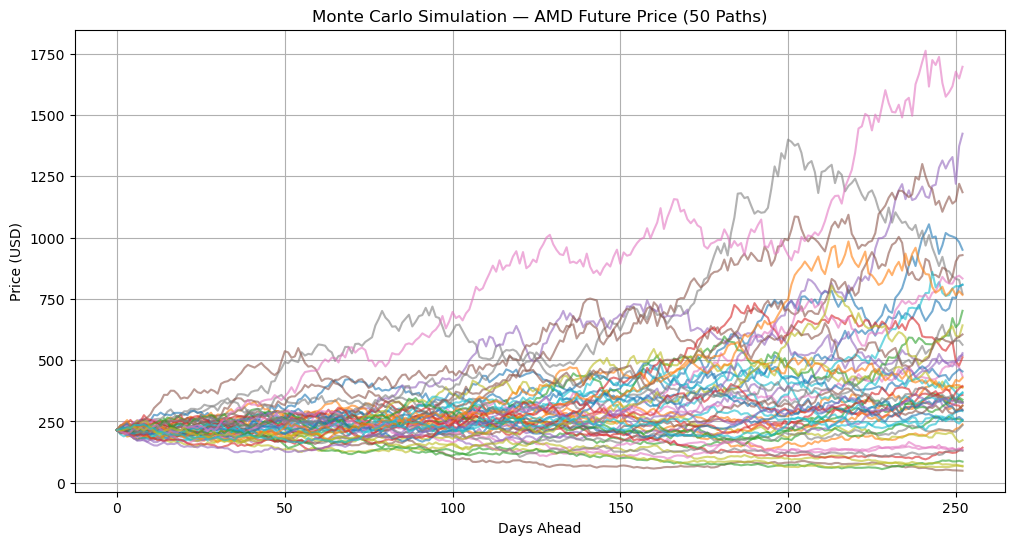

In [54]:
s = prices[-1] # the starting price
dt = 1/252

plt.figure(figsize=(12, 6))

for i in range(50):
    path = gen_yearly(s, dt, mu_yearly, sigma_yearly, 252)
    plt.plot(path, alpha=0.6)

plt.title("Monte Carlo Simulation — AMD Future Price (50 Paths)")
plt.xlabel("Days Ahead")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.show()

Let's calculate the probabilities that come from Monte Carlo.

Will the AMD gonna end higher or lower after 1 year.

In [56]:
final_prices = path[:, -1]  # get the final simulated price from each Monte Carlo
current_price = prices[-1]  # get an actual AMD today price

prob_up = np.mean(final_prices > current_price)
prob_down = np.mean(final_prices < current_price)

print(f"Probability price goes up: {prob_up}")
print(f"Probability price goes down: {prob_down}")


Probability price goes up: 0.5810276679841897
Probability price goes down: 0.4150197628458498


Based on Monte Carlo outcomes probability of going up is 58% whilst going down is 42%

Overall, the model suggest that AMD has a positive long term growth but with high uncertainty. 

### Very risky

To replicate this we just need a certain amount of datapoints of your choice

calculate daily return and yearly return

calculate Mu from regression and yearly Mu

Then feed those into Monte Carlo